# Use case for "Digital twin composition via Markov Decision Processes for resilient manufacturing"

In this notebook, we present the implementation of the use cases for the paper "Digital twin composition via Markov Decision Processes for resilient manufacturing", submitted at ICSOC 2022.

## Preliminaries

### Available services

We start with the definitions of the initial available services (with no degree of wear) and the DECLARE constraints of the task.

In [30]:
# Python imports, put at the top for simplicity
from logaut import ltl2dfa
from mdp_dp_rl.algorithms.dp.dp_analytic import DPAnalytic
from pylogics.parsers import parse_ltl

from docs.notebooks.utils import render_mdp_dfa
from docs.notebooks.utils import render_service, print_policy_data, \
    print_value_function, print_q_value_function
from icsoc_2022.declare_utils import exactly_once, absence_2, alt_succession, alt_precedence, \
    build_declare_assumption, not_coexistence
from icsoc_2022.dfa_target import mdp_from_dfa
from icsoc_2022.momdp import compute_final_mdp
from icsoc_2022.services import build_service_from_transitions, Service
from mdp_dp_rl.processes.det_policy import DetPolicy
from icsoc_2022.dfa_target import MdpDfa

In [31]:
# default economic cost value
DEFAULT_REWARD_ECONOMIC_COST = -1.0

# default quality cost value
DEFAULT_REWARD_QUALITY_COST = -1.0

# default reward when the service becomes broken
DEFAULT_BROKEN_REWARD = -2.0

# default reward to repair the device
DEFAULT_REWARD_REPAIR = -1.0

# default probability of being broken after an action
DEFAULT_BROKEN_PROB = 0.05

# default discount factor
GAMMA = 0.99

HIGH_COST = -2.0
LOW_COST = -0.5

In [32]:
# all the atomic actions for the task
BUILD_RETRIEVE_STATOR = "build_retrieve_stator"
BUILD_RETRIEVE_ROTOR = "build_retrieve_rotor"
BUILD_RETRIEVE_INVERTER = "build_retrieve_inverter"
ASSEMBLE_MOTOR = "assemble_motor"
PAINTING = "painting"
RUNNING_IN = "running_in"
ELECTRIC_TEST = "electric_test"
STATIC_TEST = "static_test"

ALL_SYMBOLS = {
    BUILD_RETRIEVE_STATOR,
    BUILD_RETRIEVE_ROTOR,
    BUILD_RETRIEVE_INVERTER,
    ASSEMBLE_MOTOR,
    PAINTING,
    RUNNING_IN,
    ELECTRIC_TEST,
    STATIC_TEST,
}

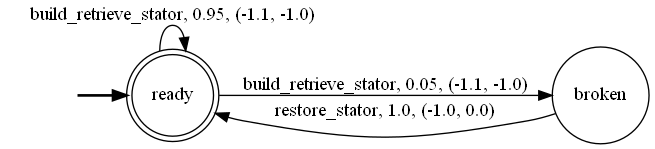

In [33]:
def stator_builder_service(
        economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST,
        quality_cost: float = DEFAULT_REWARD_QUALITY_COST,
        broken_prob: float = DEFAULT_BROKEN_PROB,
        broken_reward: float = DEFAULT_BROKEN_REWARD,
        repair_reward: float = DEFAULT_REWARD_REPAIR
) -> Service:
    """Build the stator builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob

    average_action_reward = economic_cost * (1 - broken_prob) + (economic_cost + broken_reward) * broken_prob

    transitions = {
        "ready": {
          BUILD_RETRIEVE_STATOR: ({"ready": success_prob, "broken": broken_prob}, (average_action_reward, quality_cost)),
        },
        "broken": {
            "restore_stator": ({"ready": 1.0}, (repair_reward, 0.0)),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore

service_stator_builder = stator_builder_service()
render_service(service_stator_builder)

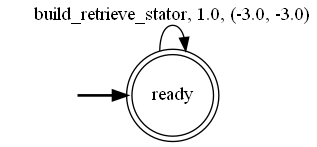

In [34]:
def stator_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the stator warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_STATOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_stator_warehouse = stator_warehouse_service(economic_cost=-3.0, quality_cost=-3.0)
render_service(service_stator_warehouse)

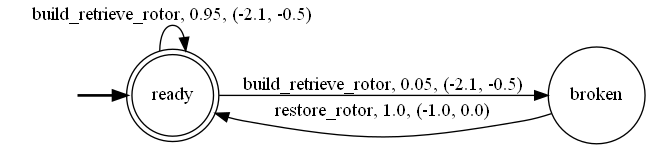

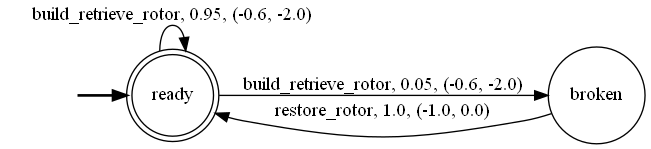

In [35]:
def rotor_builder_service(
        economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST,
        quality_cost: float = DEFAULT_REWARD_QUALITY_COST,
        broken_prob: float = DEFAULT_BROKEN_PROB,
        broken_reward: float = DEFAULT_BROKEN_REWARD,
        repair_reward: float = DEFAULT_REWARD_REPAIR
) -> Service:
    """Build the rotor builder device."""
    assert 0.0 <= broken_prob <= 1.0
    success_prob = 1.0 - broken_prob

    average_action_reward = economic_cost * (1 - broken_prob) + (economic_cost + broken_reward) * broken_prob

    transitions = {
        "ready": {
          BUILD_RETRIEVE_ROTOR: ({"ready": success_prob, "broken": broken_prob}, (average_action_reward, quality_cost)),
        },
        "broken": {
            "restore_rotor": ({"ready": 1.0}, (repair_reward, 0.0)),
        },

    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states) # type: ignore

# high economic cost - low quality cost
service_rotor_builder_1 = rotor_builder_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_rotor_builder_2 = rotor_builder_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_rotor_builder_1)
render_service(service_rotor_builder_2)

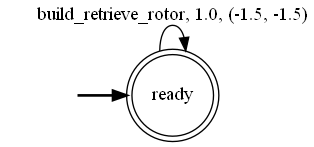

In [36]:
def rotor_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the rotor warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_ROTOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_rotor_warehouse = rotor_warehouse_service(-1.5, -1.5)
render_service(service_rotor_warehouse)

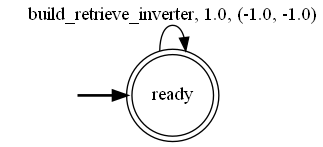

In [37]:
def inverter_warehouse_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the inverter warehouse device."""
    transitions = {
        "ready": {
            BUILD_RETRIEVE_INVERTER: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_inverter_warehouse = inverter_warehouse_service()
render_service(service_inverter_warehouse)

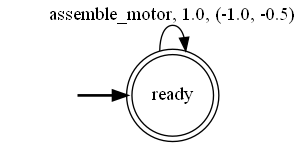

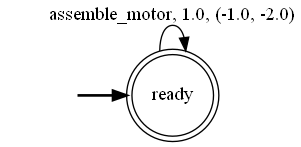

In [38]:
def assembler_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the assembler device."""
    transitions = {
        "ready": {
            ASSEMBLE_MOTOR: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_assembler_1 = assembler_service(quality_cost=LOW_COST)
# low economic cost - high quality cost
service_assembler_2 = assembler_service(quality_cost=HIGH_COST)
render_service(service_assembler_1)
render_service(service_assembler_2)

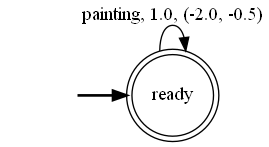

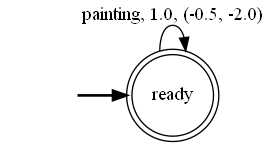

In [39]:
def painter_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the painter device."""
    transitions = {
        "ready": {
            PAINTING: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_painter_1 = painter_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_painter_2 = painter_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_painter_1)
render_service(service_painter_2)

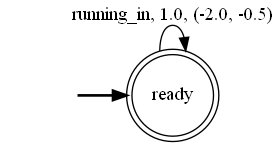

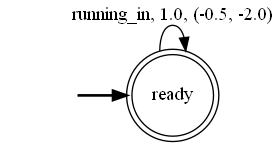

In [40]:
def smart_tester_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the smart tester device."""
    transitions = {
        "ready": {
            RUNNING_IN: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

# high economic cost - low quality cost
service_smart_tester_1 = smart_tester_service(economic_cost=HIGH_COST, quality_cost=LOW_COST)
# low economic cost - high quality cost
service_smart_tester_2 = smart_tester_service(economic_cost=LOW_COST, quality_cost=HIGH_COST)

render_service(service_smart_tester_1)
render_service(service_smart_tester_2)

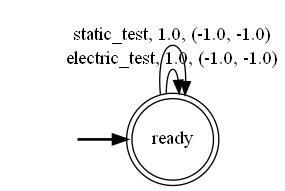

In [41]:
def mechanical_engineer_service(economic_cost: float = DEFAULT_REWARD_ECONOMIC_COST, quality_cost: float = DEFAULT_REWARD_QUALITY_COST) -> Service:
    """Build the mechanical engineer device."""
    transitions = {
        "ready": {
            ELECTRIC_TEST: ({"ready": 1.0}, (economic_cost, quality_cost)),
            STATIC_TEST: ({"ready": 1.0}, (economic_cost, quality_cost)),
        },
    }
    final_states = {"ready"}
    initial_state = "ready"
    return build_service_from_transitions(transitions, initial_state, final_states)  # type: ignore

service_mechanical_engineer = mechanical_engineer_service()
render_service(service_mechanical_engineer)

In [43]:
declare_constraints = [
    exactly_once(BUILD_RETRIEVE_STATOR),
    exactly_once(BUILD_RETRIEVE_ROTOR),
    exactly_once(BUILD_RETRIEVE_INVERTER),
    exactly_once(RUNNING_IN),
    exactly_once(ASSEMBLE_MOTOR),
    absence_2(ELECTRIC_TEST),
    absence_2(PAINTING),
    absence_2(STATIC_TEST),
    alt_succession(BUILD_RETRIEVE_STATOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_ROTOR, ASSEMBLE_MOTOR),
    alt_succession(BUILD_RETRIEVE_INVERTER, ASSEMBLE_MOTOR),
    alt_succession(ASSEMBLE_MOTOR, RUNNING_IN),
    alt_precedence(ASSEMBLE_MOTOR, PAINTING),
    alt_precedence(ASSEMBLE_MOTOR, ELECTRIC_TEST),
    alt_precedence(ASSEMBLE_MOTOR, STATIC_TEST),
    not_coexistence(ELECTRIC_TEST, STATIC_TEST),
    build_declare_assumption(ALL_SYMBOLS),
]
formula_str = " & ".join(map(lambda s: f"({s})", declare_constraints))
formula = parse_ltl(formula_str)
automaton = ltl2dfa(formula, backend="lydia")
target_mdp = mdp_from_dfa(automaton, gamma=GAMMA)
render_mdp_dfa(target_mdp)

Exception: an error occurred while running lydia: [WinError 2] Impossibile trovare il file specificato